# About
Use similarity score of input text and category description to predict input text's category.

Initial phase:
1. Create text description for each category.
2. Get the embeddings of each cateogry description.
  
Inference phase:
1. Get embedding of the input text.
2. Calculate similarity of input text's embedding against category description embeddings.
3. Based upon similarity score, predict category of the input text.

Fine tuning:
1. Improvise category description.
2. User better model for getting embeddings.

# Data

In [1]:
# categories = {
#     "affirm": "Text that expresses agreement, confirmation, or a positive response. Examples: 'Yes, I agree,' 'That’s correct,' or 'Sure, I’ll do it.'",
#     "deny": "Text that expresses disagreement, refusal, or a negative response. Examples: 'No, that’s not right,' 'I disagree,' or 'I can’t do it.'",
#     "not_sure": "Text that expresses uncertainty, doubt, or hesitation. Examples: 'I’m not sure,' 'Maybe,' or 'I need more information.'"
# }
categories = {
    "affirm": "agreement confirmation positive Yes, I agree That’s correct or Sure I’ll do it.",
    "deny": "disagreement refusal negative No, that’s not right I disagree I can’t do it.",
    "not_sure": "uncertainty doubt hesitation I’m not sure Maybe I need more information."
}

# Initial Phase
Getting embeddings of category descriptions.

## Using ollama
ollama exposes `/api/embeddings` api endpoint which we can use to get embeddings.

In [2]:
import ollama  # pip install ollama

# MODEL = "nomic-embed-text"
MODEL = "mxbai-embed-large"
HOST = "http:/localhost:11434"

In [3]:
category_embeddings = {
    category: ollama.embed(model=MODEL, input=description)["embeddings"][0]
    for category, description in categories.items()
}

# format:
# {
#     "category1": [x, x, x,....., x],
#     "category2": [...],
#     ....
# }

# Inference
Classify the category of input text.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity


def cal_similarity(v1, v2):
    return cosine_similarity([v1], [v2])


def classify(input_text: str) -> str:
    """
    Args:
        input (str): The input text that is to be classified.
    Returns:
        str: The predicted class of input text.
    """
    input_text_embedding = ollama.embed(model=MODEL, input=input_text)["embeddings"][0]
    similarities = {
        category: cal_similarity(input_text_embedding, category_embedding)
        for category, category_embedding in category_embeddings.items()
    }
    return max(similarities, key=similarities.get)


classify("Yea sure!")

'affirm'

# Evaluation

In [5]:
test_samples = [
    # affirm Examples
    {"text": "Yes, that makes perfect sense.", "category": "affirm"},
    {"text": "I completely agree with you.", "category": "affirm"},
    {"text": "Absolutely, that’s correct.", "category": "affirm"},
    {"text": "Sure thing, I’ll handle it.", "category": "affirm"},
    {"text": "Of course, that's a great idea.", "category": "affirm"},
    {"text": "Definitely, I'm on board.", "category": "affirm"},
    {"text": "Yes, I think that's the way to go.", "category": "affirm"},
    {"text": "I’m with you on that.", "category": "affirm"},
    {"text": "Totally agree with this.", "category": "affirm"},
    {"text": "Sure, that works perfectly.", "category": "affirm"},
    {"text": "Yes, that’s exactly what I was thinking.", "category": "affirm"},
    {"text": "Agreed, let’s proceed with this plan.", "category": "affirm"},
    {"text": "Without a doubt, that’s correct.", "category": "affirm"},
    {"text": "Yes, I’ll get started on it right away.", "category": "affirm"},
    {"text": "Absolutely, I support this fully.", "category": "affirm"},
    {"text": "Yes, that’s a fantastic solution.", "category": "affirm"},
    {"text": "I’m all for it!", "category": "affirm"},
    {"text": "Exactly, you’ve got it right.", "category": "affirm"},
    {"text": "Yes, I can confirm that.", "category": "affirm"},
    {"text": "Certainly, that’s a valid point.", "category": "affirm"},
    {"text": "Yes, I completely trust your judgment.", "category": "affirm"},
    {"text": "Affirmative, that’s the correct approach.", "category": "affirm"},
    {"text": "You’re absolutely right.", "category": "affirm"},
    {"text": "Yes, I’ll make it happen.", "category": "affirm"},
    {"text": "Certainly, I’ll take care of it.", "category": "affirm"},
    {"text": "Absolutely, it’s in line with my thoughts.", "category": "affirm"},
    {"text": "Yes, let’s move forward with that.", "category": "affirm"},
    {"text": "Agreed, that makes total sense.", "category": "affirm"},
    {"text": "Yes, I’m fully aligned with this.", "category": "affirm"},
    {"text": "Indeed, that’s the correct interpretation.", "category": "affirm"},
    {"text": "Absolutely, you’re spot on.", "category": "affirm"},
    {"text": "Yes, I have no objections.", "category": "affirm"},
    {"text": "I fully agree with your assessment.", "category": "affirm"},
    {"text": "Yes, that sounds like a solid plan.", "category": "affirm"},

    # deny Examples
    {"text": "No, I don’t think so.", "category": "deny"},
    {"text": "That’s not what I meant at all.", "category": "deny"},
    {"text": "I can’t agree with this.", "category": "deny"},
    {"text": "No way, that’s incorrect.", "category": "deny"},
    {"text": "No, that’s not right.", "category": "deny"},
    {"text": "I disagree with that statement.", "category": "deny"},
    {"text": "That’s not what I was suggesting.", "category": "deny"},
    {"text": "I don’t think that’s accurate.", "category": "deny"},
    {"text": "No, I can’t go along with that.", "category": "deny"},
    {"text": "I’m sorry, but that’s not correct.", "category": "deny"},
    {"text": "No, that’s not how I see it.", "category": "deny"},
    {"text": "I have to disagree with this.", "category": "deny"},
    {"text": "No, I wouldn’t support that.", "category": "deny"},
    {"text": "That’s not something I can agree to.", "category": "deny"},
    {"text": "I’m afraid that’s not true.", "category": "deny"},
    {"text": "No, that’s the wrong approach.", "category": "deny"},
    {"text": "I’m sorry, but I can’t approve that.", "category": "deny"},
    {"text": "No, I don’t think that’s the right answer.", "category": "deny"},
    {"text": "I can’t say I agree with that.", "category": "deny"},
    {"text": "No, that’s not what I’m looking for.", "category": "deny"},
    {"text": "That’s incorrect, unfortunately.", "category": "deny"},
    {"text": "I don’t support this idea.", "category": "deny"},
    {"text": "No, I don’t see it that way.", "category": "deny"},
    {"text": "That doesn’t seem right to me.", "category": "deny"},
    {"text": "No, I’m afraid that won’t work.", "category": "deny"},
    {"text": "I don’t agree with your perspective.", "category": "deny"},
    {"text": "No, I can’t accept that.", "category": "deny"},
    {"text": "Sorry, but that’s not the case.", "category": "deny"},
    {"text": "I’m not in agreement with this.", "category": "deny"},
    {"text": "No, I have to reject that.", "category": "deny"},
    {"text": "That’s not acceptable to me.", "category": "deny"},
    {"text": "I don’t think that’s the right solution.", "category": "deny"},
    {"text": "No, I can’t agree to that.", "category": "deny"},
    {"text": "I’m not convinced by this argument.", "category": "deny"},

    # not_sure Examples
    {"text": "I’m not sure if this is right.", "category": "not_sure"},
    {"text": "Maybe, but I need more information.", "category": "not_sure"},
    {"text": "It could be true, but I’m not confident.", "category": "not_sure"},
    {"text": "I don’t know for certain.", "category": "not_sure"},
    {"text": "I’m uncertain about this.", "category": "not_sure"},
    {"text": "That might be the case, but I’m not sure.", "category": "not_sure"},
    {"text": "I can’t say for sure.", "category": "not_sure"},
    {"text": "I’m on the fence about this.", "category": "not_sure"},
    {"text": "It’s possible, but I’m not confident.", "category": "not_sure"},
    {"text": "I don’t have enough information to decide.", "category": "not_sure"},
    {"text": "I’m not entirely certain.", "category": "not_sure"},
    {"text": "It’s hard to say for sure.", "category": "not_sure"},
    {"text": "I’ll need more details to confirm.", "category": "not_sure"},
    {"text": "I don’t know if that’s accurate.", "category": "not_sure"},
    {"text": "I think so, but I’m not positive.", "category": "not_sure"},
    {"text": "I’m not 100% sure about that.", "category": "not_sure"},
    {"text": "It’s not clear to me yet.", "category": "not_sure"},
    {"text": "That’s a possibility, but I can’t confirm.", "category": "not_sure"},
    {"text": "I need to think about it more.", "category": "not_sure"},
    {"text": "I’m not confident enough to say yes or no.", "category": "not_sure"},
    {"text": "It’s uncertain at this point.", "category": "not_sure"},
    {"text": "I don’t know if that’s the case.", "category": "not_sure"},
    {"text": "It’s hard to determine right now.", "category": "not_sure"},
    {"text": "I have my doubts, but I’m not certain.", "category": "not_sure"},
    {"text": "I can’t tell if that’s right or wrong.", "category": "not_sure"},
    {"text": "I’d need to verify before saying for sure.", "category": "not_sure"},
    {"text": "It’s tough to say with confidence.", "category": "not_sure"},
    {"text": "I’m not convinced either way.", "category": "not_sure"},
    {"text": "I’m still weighing the possibilities.", "category": "not_sure"},
    {"text": "I don’t have a definitive answer yet.", "category": "not_sure"},
    {"text": "That’s unclear to me right now.", "category": "not_sure"},
    {"text": "I’ll need to look into it further.", "category": "not_sure"},
    {"text": "I’m not sure how to interpret this.", "category": "not_sure"},
    {"text": "It’s not something I can confirm yet.", "category": "not_sure"}
]
edge_cases = [
    # Ambiguous/Edge Cases
    {"text": "Possibly, but I’ll have to think about it.", "category": "not_sure"},  # Uncertain tone
    {"text": "No, wait... actually, yes.", "category": "affirm"},  # Affirmative conclusion
    {"text": "I don’t think I agree with that, but I’m not certain.", "category": "not_sure"},  # Mixed tone
    {"text": "I’m sorry, I can’t do that.", "category": "deny"},  # Negative with apology
    {"text": "Yes, but I’m still a bit unsure.", "category": "affirm"},  # Affirmative with slight doubt
    {"text": "Maybe, but I’ll need more time to decide.", "category": "not_sure"},  # Uncertain tone
    {"text": "Yes, I think so, but I’m not entirely sure.", "category": "affirm"},  # Affirmative with slight doubt
    {"text": "No, I don’t think that’s right, or maybe it is?", "category": "not_sure"},  # Mixed tone
    {"text": "I’m afraid I can’t agree with this.", "category": "deny"},  # Negative with polite phrasing
    {"text": "Sure, but I’m still a little hesitant.", "category": "affirm"},  # Affirmative with hesitation
    {"text": "I don’t think I can support this, but I’ll consider it.", "category": "not_sure"},  # Mixed tone
    {"text": "Probably yes, but let me double-check.", "category": "affirm"},  # Affirmative with caveat
    {"text": "No, I don’t think so, although I could be wrong.", "category": "not_sure"},  # Negative with uncertainty
    {"text": "I don’t feel confident agreeing, but it seems plausible.", "category": "not_sure"},  # Mixed tone
    {"text": "Yes, I agree, but let’s proceed cautiously.", "category": "affirm"},  # Affirmative with caution
    {"text": "I can’t say yes right now.", "category": "deny"},  # Negative with temporal constraint
    {"text": "I might be able to agree later, but not now.", "category": "not_sure"},  # Uncertain tone with condition
    {"text": "Yes, but I’ll need further clarification.", "category": "affirm"},  # Affirmative with condition
    {"text": "No, that’s not correct... or is it?", "category": "not_sure"},  # Mixed tone
    {"text": "I want to agree, but I’m just not confident enough.", "category": "not_sure"},  # Uncertain tone
    {"text": "Yes, that’s fine, but I still have reservations.", "category": "affirm"},  # Affirmative with reservations
    {"text": "I don’t think I can agree to this, sorry.", "category": "deny"},  # Negative with apology
    {"text": "I’m leaning towards yes, but I’m not fully committed.", "category": "not_sure"},  # Mixed tone
    {"text": "Yes, I’ll agree for now.", "category": "affirm"},  # Affirmative with temporal qualifier
    {"text": "No, I can’t agree at this point in time.", "category": "deny"},  # Negative with temporal constraint
    {"text": "Possibly yes, but it depends on further details.", "category": "not_sure"},  # Uncertain tone
    {"text": "Yes, but with some conditions attached.", "category": "affirm"},  # Affirmative with caveat
    {"text": "I don’t agree with that, but I see your point.", "category": "deny"},  # Negative with acknowledgment
    {"text": "I think so, but I wouldn’t bet on it.", "category": "not_sure"},  # Mixed tone
    {"text": "No, not really, but I’m open to being convinced.", "category": "deny"},  # Negative with openness
    {"text": "Sure, but I’m hesitant to commit completely.", "category": "affirm"},  # Affirmative with hesitation
    {"text": "I don’t know if I can agree yet.", "category": "not_sure"},  # Uncertain tone
    {"text": "No, that doesn’t work for me right now.", "category": "deny"},  # Negative with temporal specificity
    {"text": "Yes, but I still need to verify a few things.", "category": "affirm"},  # Affirmative with condition
    {"text": "No, I think that’s incorrect, although I’m not entirely certain.", "category": "not_sure"}  # Mixed tone
]

not_sure : deny : I don’t think that’s accurate.
not_sure : deny : I’m afraid that’s not true.
not_sure : deny : No, I don’t think that’s the right answer.
not_sure : deny : That doesn’t seem right to me.


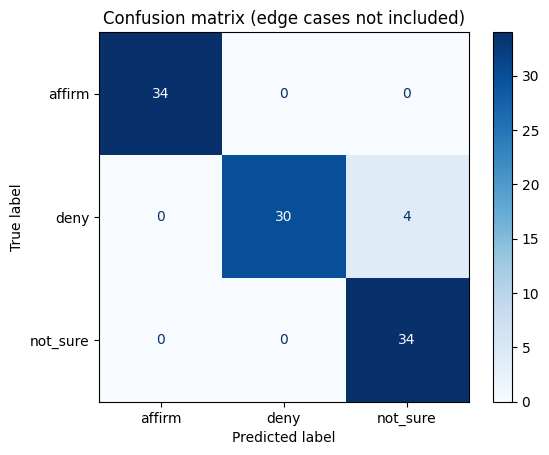

not_sure : deny : I don’t think that’s accurate.
not_sure : deny : I’m afraid that’s not true.
not_sure : deny : No, I don’t think that’s the right answer.
not_sure : deny : That doesn’t seem right to me.
not_sure : affirm : Yes, but I’m still a bit unsure.
not_sure : affirm : Yes, I think so, but I’m not entirely sure.
deny : not_sure : No, I don’t think that’s right, or maybe it is?
not_sure : affirm : Sure, but I’m still a little hesitant.
deny : not_sure : I don’t think I can support this, but I’ll consider it.
not_sure : affirm : Probably yes, but let me double-check.
not_sure : affirm : Yes, I agree, but let’s proceed cautiously.
deny : not_sure : I might be able to agree later, but not now.
not_sure : affirm : Yes, but I’ll need further clarification.
deny : not_sure : No, that’s not correct... or is it?
not_sure : affirm : Yes, that’s fine, but I still have reservations.
not_sure : deny : No, not really, but I’m open to being convinced.
not_sure : affirm : Sure, but I’m hesitan

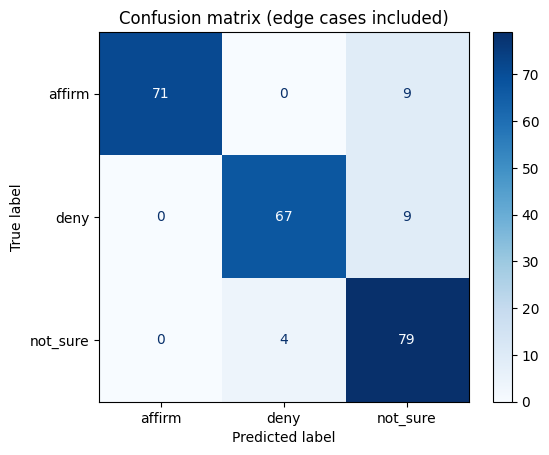

Full(edge cases included) classification report:
              precision    recall  f1-score   support

      affirm       1.00      0.89      0.94        80
        deny       0.94      0.88      0.91        76
    not_sure       0.81      0.95      0.88        83

    accuracy                           0.91       239
   macro avg       0.92      0.91      0.91       239
weighted avg       0.92      0.91      0.91       239



In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

true_categories = []
predicted_categories = []

test_data = test_samples
for sample in test_data:
    predicted = classify(sample["text"])
    true_categories.append(sample["category"])
    predicted_categories.append(predicted)
    if predicted != sample["category"]:
        print(f'{predicted} : {sample["category"]} : {sample["text"]}')

# display confusino matrix
cm = confusion_matrix(true_categories, predicted_categories, labels=list(categories.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix (edge cases not included)")
plt.show()

test_data = test_data + edge_cases
for sample in test_data:
    predicted = classify(sample["text"])
    true_categories.append(sample["category"])
    predicted_categories.append(predicted)
    if predicted != sample["category"]:
        print(f'{predicted} : {sample["category"]} : {sample["text"]}')

# display confusino matrix
cm = confusion_matrix(true_categories, predicted_categories, labels=list(categories.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix (edge cases included)")
plt.show()

# print classification report
print("Full(edge cases included) classification report:")
report = classification_report(true_categories, predicted_categories, labels=list(categories.keys()))
print(report)

Improvement prospectives:
- **Clustering on Embedding**: Instead of comparing with embedding of just category description, we could get average embedding from all training data (+ edge cases) and use that instead.
- Improving description and getting better embedding model.